In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

# Load neighborhood boundaries shapefile with specified encoding
gdf_neighborhood = gpd.read_file('../../datasets/boundaries/neighborhood/raw/BND_ADM_DONG_PG.shp', encoding='cp949')
# Filter neighborhoods where ADM_CD starts with '11' (Seoul)
gdf_neighborhood_seoul = gdf_neighborhood[gdf_neighborhood['ADM_CD'].astype(str).str.startswith('11')]

gdf_neighborhood_seoul

,BASE_DATE,ADM_CD,ADM_NM,geometry
69,20240630,11240750,잠실4동,"POLYGON ((210330.090 547163.722, 210326.158 54..."
552,20240630,11240780,잠실7동,"POLYGON ((206502.446 544771.474, 206494.684 54..."
734,20240630,11240790,잠실2동,"POLYGON ((207564.725 545798.428, 207564.263 54..."
847,20240630,11240770,잠실6동,"POLYGON ((208949.521 547174.423, 208975.386 54..."
917,20240630,11240580,방이2동,"POLYGON ((209981.565 546446.632, 210067.824 54..."
...,...,...,...,...
3170,20240630,11120720,불광2동,"POLYGON ((194734.435 558496.906, 194738.067 55..."
3171,20240630,11120730,응암3동,"POLYGON ((192855.159 555162.328, 192855.111 55..."
3172,20240630,11130660,홍은1동,"POLYGON ((195073.319 554716.263, 195036.172 55..."
3173,20240630,11190660,신길4동,"POLYGON ((192586.782 545131.532, 192588.556 54..."


<Axes: >

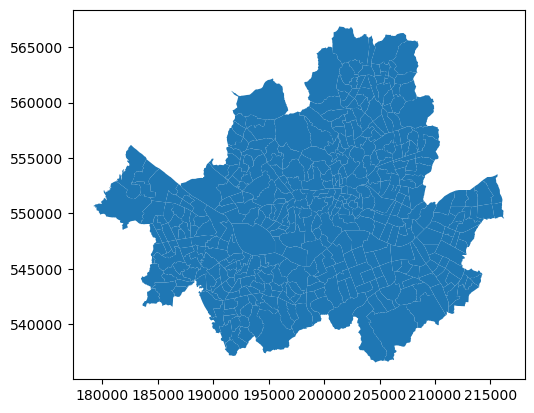

In [2]:
gdf_neighborhood_seoul.plot()

In [3]:
# import urban center gis,
gdf_center = gpd.read_file('../../datasets/centers/raw/UPIS_SHP_ZON500.shp', encoding='cp949')

# set CRS to EPSG:5174 (GRS80)
gdf_center = gdf_center.set_crs('EPSG:5174')


# Create type column using LABEL column
def classify_center_type(label):
    if '도심' in label:
        return 'city_center'
    elif '광역중심' in label or '광역 중심' in label:
        return 'regional_center'
    elif '지역중심' in label or '지역 중심' in label:
        return 'district_center'
    elif '지구중심' in label or '지구 중심' in label:
        return 'neighborhood_center'
    else:
        return 'others'

# Create type column
gdf_center['type'] = gdf_center['LABEL'].apply(classify_center_type)

# Check results
print("center_type distribution:")
print(gdf_center['type'].value_counts())

center_type distribution:
neighborhood_center    52
district_center        12
city_center             6
regional_center         6
Name: type, dtype: int64


<Axes: >

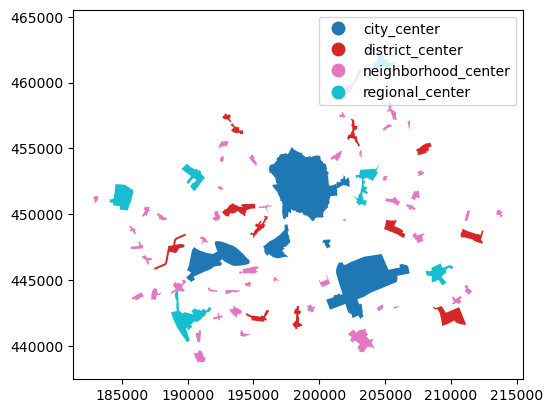

In [4]:
# coloring the map by center type
gdf_center.plot(column='type', legend=True)

In [5]:
# Mapping centers to neighborhoods
# Perform spatial join to map centers to neighborhoods

# Change CRS of gdf_center to match gdf_neighborhood_seoul
gdf_center = gdf_center.to_crs(gdf_neighborhood_seoul.crs)

# Perform spatial intersection to calculate overlapping areas
gdf_intersection = gpd.overlay(gdf_neighborhood_seoul, gdf_center, how='intersection')
gdf_intersection['intersection_area'] = gdf_intersection.geometry.area

# For each neighborhood, find the center type with maximum overlap and sum total intersection area
def process_neighborhood_intersections(group):
    # Sum all intersection areas for this neighborhood
    total_intersection_area = group['intersection_area'].sum()
    
    # Find the center type with maximum intersection area
    max_overlap_idx = group['intersection_area'].idxmax()
    dominant_center_type = group.loc[max_overlap_idx, 'type']
    
    return pd.Series({
        'intersection_area': total_intersection_area,
        'type': dominant_center_type
    })

# Group by neighborhood and apply the processing function
intersection_summary = gdf_intersection.groupby('ADM_CD').apply(process_neighborhood_intersections).reset_index()

# Merge back to the original neighborhood data
gdf_neighborhood_seoul = gdf_neighborhood_seoul.merge(intersection_summary[['ADM_CD', 'type', 'intersection_area']], on='ADM_CD', how='left')

# Fill NaN values for neighborhoods without centers
gdf_neighborhood_seoul['intersection_area'].fillna(0, inplace=True)
gdf_neighborhood_seoul['type'] = gdf_neighborhood_seoul['type'].fillna('none')

gdf_neighborhood_seoul['area'] = gdf_neighborhood_seoul.geometry.area

# Check results
print("Final type distribution:")
print(gdf_neighborhood_seoul['type'].value_counts())
print(f"Neighborhoods with multiple center overlaps: {(gdf_intersection.groupby('ADM_CD').size() > 1).sum()}")

Final type distribution:
none                   155
neighborhood_center    110
city_center             72
district_center         52
regional_center         37
Name: type, dtype: int64
Neighborhoods with multiple center overlaps: 48


In [6]:
gdf_neighborhood_seoul

,BASE_DATE,ADM_CD,ADM_NM,geometry,type,intersection_area,area
0,20240630,11240750,잠실4동,"POLYGON ((210330.090 547163.722, 210326.158 54...",regional_center,898.203529,7.802034e+05
1,20240630,11240780,잠실7동,"POLYGON ((206502.446 544771.474, 206494.684 54...",city_center,319004.279584,7.234864e+05
2,20240630,11240790,잠실2동,"POLYGON ((207564.725 545798.428, 207564.263 54...",city_center,325389.060207,2.686851e+06
3,20240630,11240770,잠실6동,"POLYGON ((208949.521 547174.423, 208975.386 54...",regional_center,287331.847106,1.508001e+06
4,20240630,11240580,방이2동,"POLYGON ((209981.565 546446.632, 210067.824 54...",regional_center,198074.549784,7.698410e+05
...,...,...,...,...,...,...,...
421,20240630,11120720,불광2동,"POLYGON ((194734.435 558496.906, 194738.067 55...",none,0.000000,1.396089e+06
422,20240630,11120730,응암3동,"POLYGON ((192855.159 555162.328, 192855.111 55...",neighborhood_center,130366.324980,7.527729e+05
423,20240630,11130660,홍은1동,"POLYGON ((195073.319 554716.263, 195036.172 55...",none,0.000000,1.598759e+06
424,20240630,11190660,신길4동,"POLYGON ((192586.782 545131.532, 192588.556 54...",none,0.000000,3.226015e+05


In [9]:
# Create output directory if it doesn't exist
import os
output_dir = '../../datasets/boundaries/neighborhood/processed/'
os.makedirs(output_dir, exist_ok=True)

# Save as shapefile with proper encoding
gdf_neighborhood_seoul.to_file(
    '../../datasets/boundaries/neighborhood/processed/neighborhoods_with_center_type.shp', 
    driver='ESRI Shapefile',
    encoding='cp949'
)

C:\Users\seung\AppData\Local\Temp\ipykernel_12292\3518720107.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_neighborhood_seoul.to_file(
